***COURT HEARING***

Пусть 
a1 - факт того, что подсудимый виновен,
b1 - факт того, что у случайного жителя указанная группа крови

Прокурор утверждает, что p(b1 | не a1) = 0.01, а значит p(a1 | b1) = 1 - p(не a1 | b1) = 1 - p(b1 | не a1) = 0.99, однако это в корне неверно, т.к. p(не a1 | b1) != p(b1 | не a1)


Адвокат утверждает, что раз p(a1 | b1) = 10^-4, то подсудимый невиновен и нужно исключить оказательство из дела.
Но во-первых, p(a1) = 10^-6 что в 100 раз меньше по сравнению со случаем, когда мы значем группу крови, 
а во вторых это все еще не совсем та вероятность, которая нам нужна.

Пусть
с1 - факт того, что рассматриваемый человек является подсудимым

На самом деле мы ищем уже вот такую вероятность:
    
p(a1 | b1, c1) = p(a1c1 | b1) / p(c1)

и вот эта вероятность будет уже гораздо больше, чем 10^-4

То есть мы ищем вероятность того, что человек, который является подозреваемым и 
группа крови которого совпала с группой крови убийцы реально совершил убийство.
И если поднять статистику скорее всего окажется, что среди людей подозреваемых в убийстве среди тех подозреваемых, 
у кого совпала группа крови с убийцей, процент реальных убийц был гораздо выше.
Поэтому доказательство исключать из дела не нельзя.

***DISEASE***

In [409]:
import numpy as np
PRIOR = 0.01

def p_d_t(fp, prior):
    return ((1 - fp) * prior) / ((1 - fp) * prior + (fp) * (1 - prior))

def p_d_not_t(fn, prior):
    return (fn * prior) / (fn * prior + (1 - fn) * (1 - prior))

false_positive_probabilities = np.linspace(0.05, 0.001, 50)
false_negative_probabilities = np.linspace(0.05, 0.001, 50)

aposterior_decease_probability_test = [1 - p_d_t(x, PRIOR) for x in false_positive_probabilities]
aposterior_decease_probability_not_test = [p_d_not_t(x, PRIOR) for x in false_negative_probabilities]

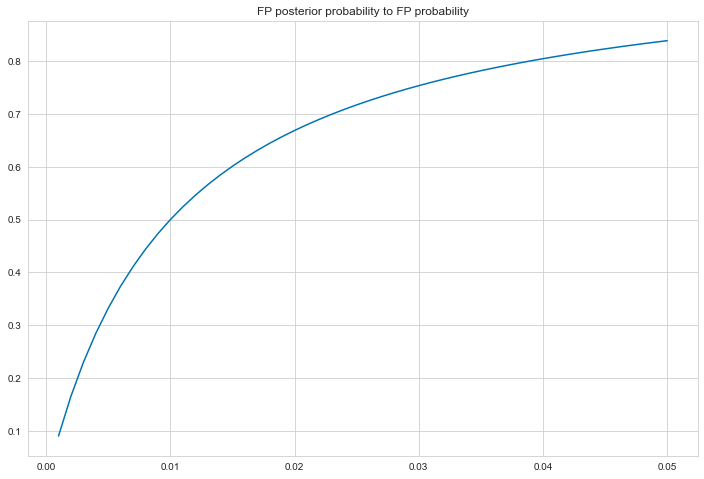

In [411]:
from matplotlib import pyplot as plt
fig = plt.figure(figsize=(12, 8))
plt.title('FP posterior probability to FP probability')
plt.plot([x for x in false_positive_probabilities], aposterior_decease_probability_test)

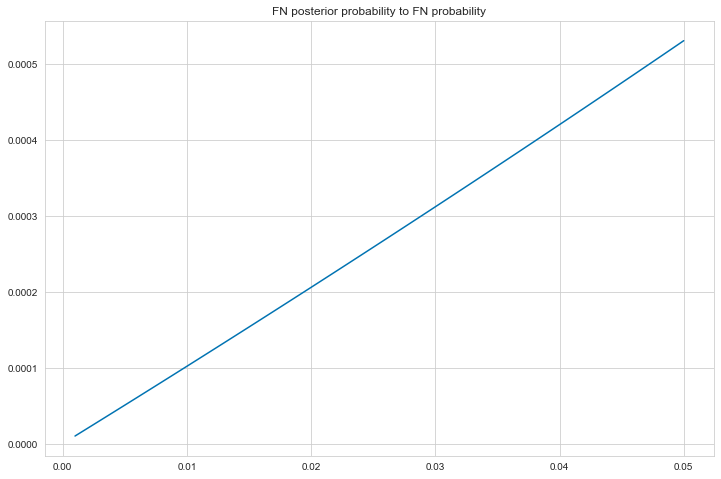

In [404]:
fig = plt.figure(figsize=(12, 8))
plt.title('FN posterior probability to FN probability')
plt.plot([x for x in false_negative_probabilities], aposterior_decease_probability_not_test)

Вывод:
Вероятнее всего нам интересно уменьшать именно FP ошибки, 
т.к. в 16% в случае положительного теста это почти бесполезный результат, который не позволяет принимать каких-либо решений.
Однако на самом деле все зависит от того, что важнее для людей, которые проводят тест.
Если окажется так, что болезнь жутко заразная и смертность 100% если не пролечить человека, то имеет смысл минимизировать уже FN для того, чтобы спасти больше жизней.
Однако же, если лекартв мало, повторные тесты делать дорого и мы не можем просто всех подряд постадить в букнер на самоизоляцию, 
то хорошо бы минимизировать уже FP, потому что тогда по крайней мере мы будем точнее знать, на каких людей е требуется тратить ресурсы.


***CORONA***

In [810]:
import pandas as pd
import datetime
import numpy as np
from sklearn.linear_model import LinearRegression
df = pd.read_csv('owid-covid-data.csv')
data = df[df['location'] == 'Russia'][df['date'] >= '2020-03-03'][['date', 'new_cases', 'total_cases']]
data.new_cases = data.new_cases.apply(lambda x: 1 if x < 1 else x)
data.total_cases = data.total_cases.apply(lambda x: 1 if x < 1 else x)
data['date_delta'] = data.date.apply(lambda x: (datetime.datetime.strptime(x, '%Y-%m-%d') - datetime.datetime(2020, 3, 3)).days)
data_train = data[data.date_delta < 50]
data_test = data[data.date_delta >= 50]

C:\ProgramData\Anaconda3\envs\dl_made_transformers_pytorch\lib\site-packages\ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


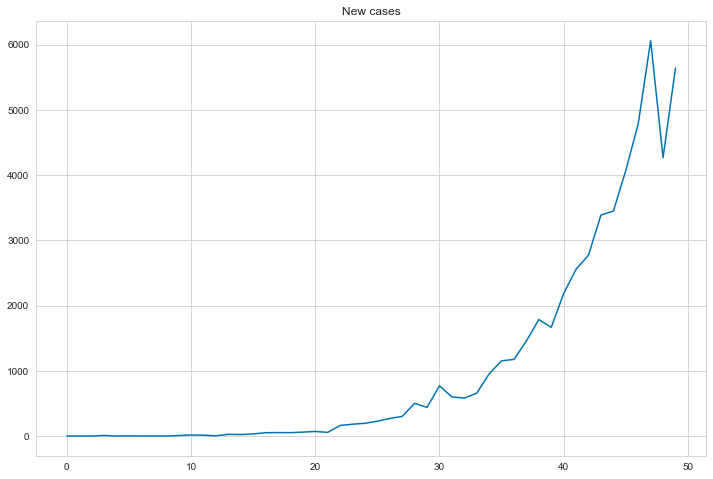

In [811]:
fig = plt.figure(figsize=(12, 8))
plt.title('New cases')
plt.plot(data_train.date_delta, data_train.new_cases)

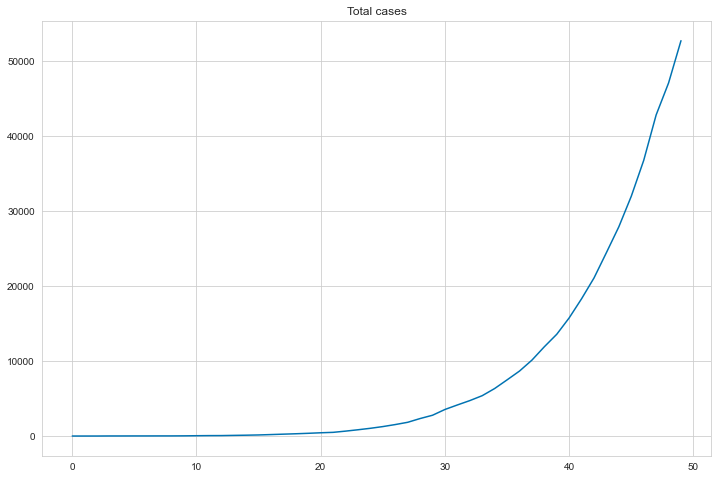

In [812]:
fig = plt.figure(figsize=(12, 8))
plt.title('Total cases')
plt.plot(data_train.date_delta, data_train.total_cases)

In [813]:
t = np.array(data_train.date_delta) + 1
y = np.log(np.array(data_train.new_cases))
y2 = np.log(np.array(data_train.total_cases))

In [814]:
# Fitting linear regression
lr = LinearRegression().fit(t.reshape(-1, 1), y2)
w0, w1, sigma0 = lr.intercept_, lr.coef_[0], np.sqrt(np.sum((lr.intercept_ + lr.coef_[0] * t - y2) ** 2) / len(t))

In [815]:
def bayesian_update(mu, sigma, x, y, sigma_noise=.5):
    x_matrix = np.array([[1, x]])
    sigma_n = np.linalg.inv(np.linalg.inv(sigma)+ (1 / (sigma_noise ** 2)) * np.matmul(np.transpose(x_matrix), x_matrix) )
    mu_n = np.matmul(sigma_n, np.matmul(np.linalg.inv(sigma), np.transpose(mu)) + (1 / (sigma_noise ** 2)) * np.matmul(np.transpose(x_matrix), np.array([y]) ) )
    return mu_n, sigma_n

In [816]:
px, py = t[0], y2[0]
base_mu, base_sigma = np.array([w0, w1]), sigma0*np.array([[1, 0], [0, 1]])
cur_mu, cur_sigma = bayesian_update(base_mu, base_sigma, px, py)

In [818]:
def myplot_sample_lines2(mu, sigma, n=20, points=None):
    my_w = np.random.multivariate_normal(mu, sigma, n)
    for w in my_w:
        plt.plot(t, np.exp(w[0] + w[1]*t), 'k-', lw=.4)
    plt.ylim((0, 500))
    plt.xlim((0, 50))
    if not points is None:
        plt.scatter(points[0], points[1], marker='*', s=200)

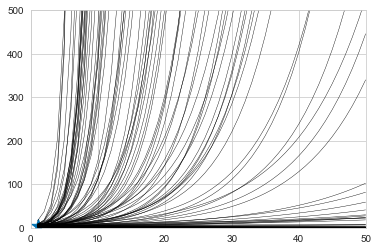

In [819]:
# Посемплированные экспоненты
myplot_sample_lines2(cur_mu, cur_sigma, 200, points=[[px], [np.exp(py)]])

In [831]:
import seaborn as sns
sns.set_style("whitegrid")
sns.set_palette("colorblind")
palette = sns.color_palette()
figsize = (15,8)
legend_fontsize = 16
# Нарисуем результат
def plot_predictions2(xs, mu, x, points):
    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(111)
    ax.set_xlim((xs[0], xs[-1]))
    ax.set_ylim((-100000, 500000))
#     ax.plot(xs, true_curve(xs), label="Правильный ответ")
    ax.plot(xs, np.exp(mu[1]*xs + mu[0]), color="red", label="MAP гипотеза")
#     ax.fill_between(xs, mu[1]*xs + mu[0] - .25, mu[1]*xs + mu[0] + .25, color=palette[1], alpha=.3, label="+- дисперсия шума")
    ax.fill_between(xs, np.mean(x, axis=0) - np.std(x, axis=0), np.mean(x, axis=0) + np.std(x, axis=0), color=palette[5], alpha=.2, label="+- дисперсия предсказаний")
    ax.scatter(points[0], points[1], marker='*', s=200)
    ax.legend(fontsize=legend_fontsize)

In [821]:
# Посэмплируем прямые и выдадим статистики по предсказаниям
def sample_statistics2(mu, sigma, xs, n=20):
    my_w = np.random.multivariate_normal(mu, sigma, n)
    res = np.zeros((n, xs.shape[0]))
    for i,w in enumerate(my_w):
        res[i,:] = np.exp(w[0] + w[1]*xs)
    return res

In [832]:
print("Случаев коронавируса предсказано к 1 мая (update по одной точке)", round(np.exp(cur_mu[0] + cur_mu[1]*60)))
print("Случаев коронавируса предсказано к 1 июня (update по одной точке)", round(np.exp(cur_mu[0] + cur_mu[1]*90)))
print("Случаев коронавируса предсказано к 1 сентября (update по одной точке)", round(np.exp(cur_mu[0] + cur_mu[1]*180)))

Случаев коронавируса предсказано к 1 мая (update по одной точке) 0
Случаев коронавируса предсказано к 1 июня (update по одной точке) 0
Случаев коронавируса предсказано к 1 сентября (update по одной точке) 0


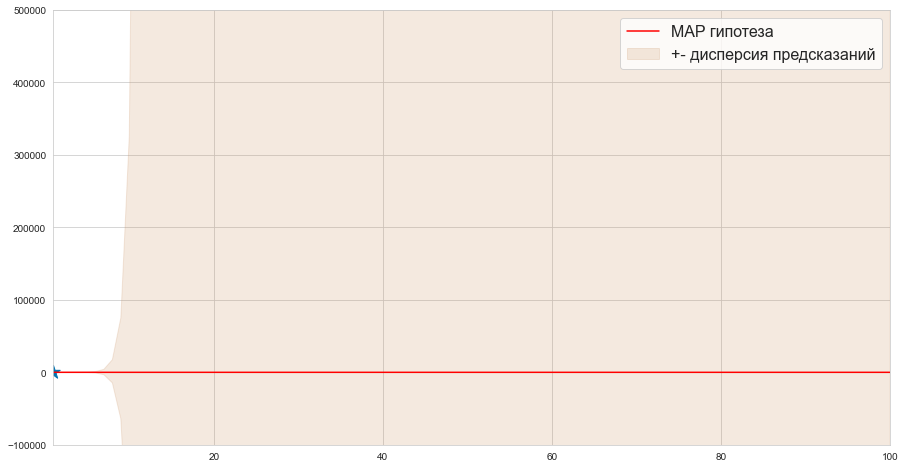

In [833]:
x = sample_statistics2(cur_mu, cur_sigma, np.linspace(1, 100, 100), n=1000)
plot_predictions2(np.linspace(1, 100, 100), cur_mu, x, [[px], [np.exp(py)]])

In [824]:
px2, py2 = t[1], y2[1]
cur_mu2, cur_sigma2 = bayesian_update(cur_mu, cur_sigma, px2, py2)

In [825]:
for i in range(2, 50):
    px2, py2 = t[i], y2[i]
    cur_mu2, cur_sigma2 = bayesian_update(cur_mu2, cur_sigma2, px2, py2)

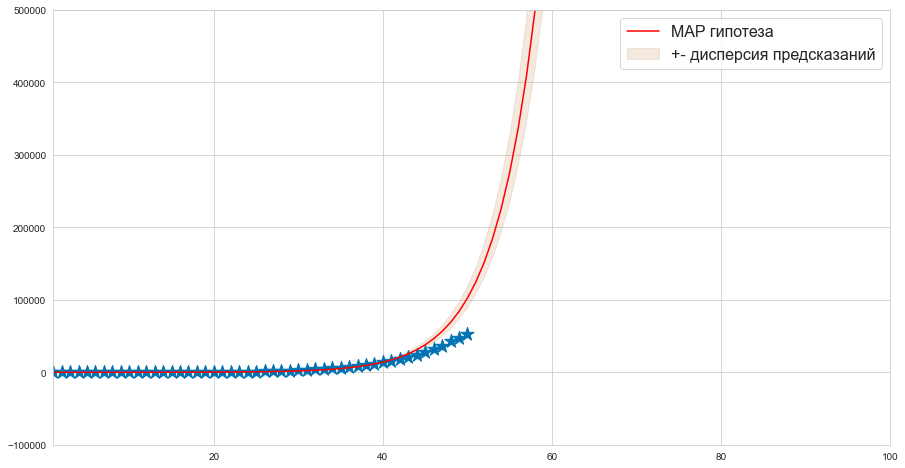

In [834]:
x = sample_statistics2(cur_mu2, cur_sigma2, np.linspace(1, 100, 100), n=1000)
plot_predictions2(np.linspace(1, 100, 100), cur_mu2, x, [t, [np.exp(y2)]])

In [829]:
print("Суммарно случаев коронавируса предсказано к 1 мая", round(np.exp(cur_mu2[0] + cur_mu2[1]*60)))
print("Суммарно случаев случаев коронавируса предсказано к 1 июня", round(np.exp(cur_mu2[0] + cur_mu2[1]*90)))
print("Суммарно случаев случаев коронавируса предсказано к 1 сентября", round(np.exp(cur_mu2[0] + cur_mu2[1]*180)))

Суммарно случаев коронавируса предсказано к 1 мая 744078
Суммарно случаев случаев коронавируса предсказано к 1 июня 285179210
Суммарно случаев случаев коронавируса предсказано к 1 сентября 16055220508205470


***Probit fitting***

In [794]:
y_new = np.array(y)
lr_new = LinearRegression().fit([(x, x*x) for x in t], y_new)

In [795]:
# Posterior
w0_new, w1_new, w2_new, sigma0_new = lr_new.intercept_, lr_new.coef_[0], lr_new.coef_[1], np.sqrt(np.sum((lr_new.intercept_ + lr_new.coef_[0] * t + lr_new.coef_[1] * (t ** 2) - y_new) ** 2) / len(t))

In [796]:
def bayesian_update_new(mu, sigma, x, y, sigma_noise=.5):
    x_matrix = np.array([[1, x, x*x]])
    sigma_n = np.linalg.inv(np.linalg.inv(sigma) + (1 / (sigma_noise ** 2)) * np.matmul(np.transpose(x_matrix), x_matrix) )
    mu_n = np.matmul(sigma_n, np.matmul(np.linalg.inv(sigma), np.transpose(mu)) + (1 / (sigma_noise ** 2)) * np.matmul(np.transpose(x_matrix), np.array([y]) ) )
    return mu_n, sigma_n

In [797]:
px_new, py_new = t[0], y_new[0]
base_mu_new, base_sigma_new = np.array([w0_new, w1_new, w2_new]), sigma0_new*np.array([[1, 0, 0], [0, 1, 0], [0, 0, 1]])
cur_mu_new, cur_sigma_new = bayesian_update_new(base_mu_new, base_sigma_new, px_new, py_new)

C:\ProgramData\Anaconda3\envs\dl_made_transformers_pytorch\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: overflow encountered in exp
  import sys
C:\ProgramData\Anaconda3\envs\dl_made_transformers_pytorch\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: overflow encountered in exp
  import sys
C:\ProgramData\Anaconda3\envs\dl_made_transformers_pytorch\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: overflow encountered in exp
  import sys
C:\ProgramData\Anaconda3\envs\dl_made_transformers_pytorch\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: overflow encountered in exp
  import sys
C:\ProgramData\Anaconda3\envs\dl_made_transformers_pytorch\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: overflow encountered in exp
  import sys
C:\ProgramData\Anaconda3\envs\dl_made_transformers_pytorch\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: overflow encountered in exp
  import sys
C:\ProgramData\Anaconda3\envs\dl_made_transfor

C:\ProgramData\Anaconda3\envs\dl_made_transformers_pytorch\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: overflow encountered in exp
  import sys
C:\ProgramData\Anaconda3\envs\dl_made_transformers_pytorch\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: overflow encountered in exp
  import sys
C:\ProgramData\Anaconda3\envs\dl_made_transformers_pytorch\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: overflow encountered in exp
  import sys
C:\ProgramData\Anaconda3\envs\dl_made_transformers_pytorch\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: overflow encountered in exp
  import sys
C:\ProgramData\Anaconda3\envs\dl_made_transformers_pytorch\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: overflow encountered in exp
  import sys
C:\ProgramData\Anaconda3\envs\dl_made_transformers_pytorch\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: overflow encountered in exp
  import sys
C:\ProgramData\Anaconda3\envs\dl_made_transfor

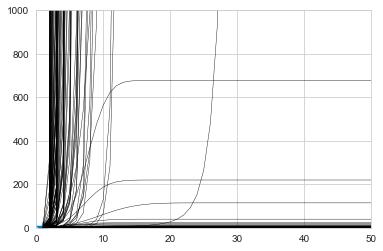

In [800]:
def myplot_sample_lines_new(mu, sigma, n=20, points=None):
    # Посэмплируем и порисуем прямые
    my_w = np.random.multivariate_normal(mu, sigma, n)

    # plt.axis('equal')
    for w in my_w:
        plt.plot(t, np.cumsum(np.exp(w[0] + w[1]*t + w[2]*(t**2))), 'k-', lw=.4)
    plt.ylim((0, 1000))
    plt.xlim((0, 50))
    if not points is None:
        plt.scatter(points[0], points[1], marker='*', s=200)
myplot_sample_lines_new(cur_mu_new, cur_sigma_new, 200, points=[[px_new], [np.exp(y_new[0])]])

In [871]:
def plot_predictions_new(xs, mu, x, points):
    points_given = [points[0][0][:50], points[1][0][:50]]
    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(111)
    ax.set_xlim((xs[0], xs[-1]))
    ax.set_ylim((-100000, 2000000))
    ax.plot(np.array(points[0][0]), np.array(points[1][0]), label="Реальные данные")
    ax.plot(xs, np.cumsum(np.exp(mu[2]*(xs**2) + mu[1]*xs + mu[0])), color="red", label="MAP гипотеза")
#     ax.fill_between(xs, mu[1]*xs + mu[0] - .25, mu[1]*xs + mu[0] + .25, color=palette[1], alpha=.3, label="+- дисперсия шума")
    ax.fill_between(xs, np.mean(x, axis=0) - np.std(x, axis=0), np.mean(x, axis=0) + np.std(x, axis=0), color=palette[5], alpha=.2, label="+- дисперсия предсказаний")
    ax.scatter(np.array(points_given[0]), np.array(points_given[1]), marker='*', s=200)
    ax.legend(fontsize=legend_fontsize)

def sample_statistics_new(mu, sigma, xs, n=20):
    my_w = np.random.multivariate_normal(mu, sigma, n)
    res = np.zeros((n, xs.shape[0]))
    for i,w in enumerate(my_w):
        res[i,:] = np.cumsum(np.exp(w[0] + w[1]*xs + w[2]*(xs**2)))
    return res

In [802]:
px_new_2, py_new_2 = t[1], y_new[1]
cur_mu_new_2, cur_sigma_new_2 = bayesian_update_new(cur_mu_new, cur_sigma_new, px_new, py_new)
for i in range(2, 50):
    px_new_2, py_new_2 = t[i], y_new[i]
    cur_mu_new_2, cur_sigma_new_2 = bayesian_update_new(cur_mu_new_2, cur_sigma_new_2, px_new_2, py_new_2)

In [808]:
print("Всего случаев коронавируса предсказано к 1 мая", round(np.cumsum(np.exp(cur_mu_new_2[0] + cur_mu_new_2[1]*np.array([range(1, 60)]) + cur_mu_new_2[2]*(np.array([range(1, 60)])**2)))[-1]))
print("Всего случаев коронавируса предсказано к 1 июня", round(np.cumsum(np.exp(cur_mu_new_2[0] + cur_mu_new_2[1]*np.array([range(1, 90)]) + cur_mu_new_2[2]*(np.array([range(1, 90)])**2)))[-1]))
print("Всего случаев коронавируса предсказано к 1 сентября", round(np.cumsum(np.exp(cur_mu_new_2[0] + cur_mu_new_2[1]*np.array([range(1, 180)]) + cur_mu_new_2[2]*(np.array([range(1, 180)])**2)))[-1]))

Всего случаев коронавируса предсказано к 1 мая 141136
Всего случаев коронавируса предсказано к 1 июня 774583
Всего случаев коронавируса предсказано к 1 сентября 1023231


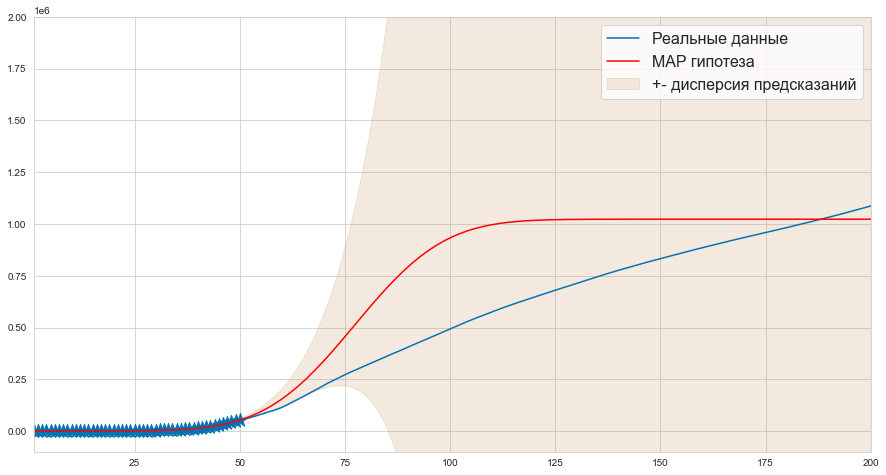

In [872]:
x = sample_statistics_new(cur_mu_new_2, cur_sigma_new_2, np.linspace(1, 200, 200), n=1000)
plot_predictions_new(np.linspace(1, 200, 200), cur_mu_new_2, x, [[data.date_delta + 1], [data.total_cases]])

Как видно из графика, сигмоида гораздо лучше описывает реальную ситуацию с будущим количеством заболевших, чем экспонента. Также, есть определенные вопросы к тому, как именно велась статистика после 50 дня, так как уж слишком форма реального графика похожа на линейную функцию.